# Open Meteo
Open-Meteo is an open-source weather API and offers free access for non-commercial use. </br>No API key required.

## EDA - Clima en Nueva York

Este EDA se enfoca en examinar las variables climáticas relevantes que podrían impactar en el transporte de vehículos en la ciudad de Nueva York.

### Coordenadas Geográficas

Las coordenadas geográficas de Nueva York son las siguientes:

- **Latitud:** 40.714°
- **Longitud:** -74.006°

### Rango de Fechas

El análisis abarca el período comprendido entre:

- **Fecha de inicio:** 2020-01-01
- **Fecha de fin:** 2023-12-31

### Estructura del Dataset

| Variable                              | Valid time            | Unit         | Description                                                                                                              |
|---------------------------------------|-----------------------|--------------|--------------------------------------------------------------------------------------------------------------------------|
| temperature_2m                        | Instant               | °C (°F)      | Air temperature at 2 meters above ground                                                                                 |
| relative_humidity_2m                  | Instant               | %            | Relative humidity at 2 meters above ground                                                                              |
| apparent_temperature                  | Instant               | °C (°F)      | Apparent temperature is the perceived feels-like temperature combining wind chill factor, relative humidity, and solar radiation |
| precipitation                         | Preceding hour sum    | mm (inch)    | Total precipitation (rain, showers, snow) sum of the preceding hour. Data is stored with a 0.1 mm precision. If precipitation data is summed up to monthly sums, there might be small inconsistencies with the total precipitation amount. |
| rain                                  | Preceding hour sum    | mm (inch)    | Only liquid precipitation of the preceding hour including local showers and rain from large scale systems.             |
| snowfall                              | Preceding hour sum    | cm (inch)    | Snowfall amount of the preceding hour in centimeters. For the water equivalent in millimeter, divide by 7. E.g. 7 cm snow = 10 mm precipitation water equivalent |
| snow_depth                            | Instant               | meters       | Snow depth on the ground. Snow depth in ERA5-Land tends to be overestimated. As the spatial resolution for snow depth is limited, please use it with care. |
| cloud_cover_low                       | Instant               | %            | Low level clouds and fog up to 2 km altitude                                                                            |
| wind_speed_10m                        | Instant               | km/h (mph, m/s, knots) | Wind speed at 10 or 100 meters above ground. Wind speed on 10 meters is the standard level.                         |
| wind_gusts_10m                        | Instant               | km/h (mph, m/s, knots) | Gusts at 10 meters above ground of the indicated hour. Wind gusts in CERRA are defined as the maximum wind gusts of the preceding hour. Please consult the ECMWF IFS documentation for more information on how wind gusts are parameterized in weather models. |


In [1]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
# Latitud and Longitude are from NYC
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 40.714, 
	"longitude": -74.006,
	"start_date": "2020-01-01",
	"end_date": "2023-12-31",
	"hourly": ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "precipitation", "rain", "snowfall", "snow_depth", "cloud_cover_low", "wind_speed_10m", "wind_gusts_10m"],
	"timezone": "America/New_York"
}

In [2]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(2).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()
hourly_rain = hourly.Variables(4).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(5).ValuesAsNumpy()
hourly_snow_depth = hourly.Variables(6).ValuesAsNumpy()
hourly_cloud_cover_low = hourly.Variables(7).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(8).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(9).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s"),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["snow_depth"] = hourly_snow_depth
hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)

Coordinates 40.738136291503906°E -74.04254150390625°N
Elevation 37.0 m asl
Timezone b'America/New_York' b'EST'
Timezone difference to GMT+0 -18000 s


In [3]:
hourly_dataframe

,date,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,cloud_cover_low,wind_speed_10m,wind_gusts_10m
0,2020-01-01 05:00:00,3.0635,73.918938,-1.807430,0.0,0.0,0.0,0.0,0.0,17.673029,29.160000
1,2020-01-01 06:00:00,1.9135,76.475830,-2.886475,0.0,0.0,0.0,0.0,0.0,16.559999,29.160000
2,2020-01-01 07:00:00,1.4135,78.969551,-3.394002,0.0,0.0,0.0,0.0,0.0,16.563911,27.719999
3,2020-01-01 08:00:00,1.0635,76.899399,-4.152611,0.0,0.0,0.0,0.0,0.0,18.723459,31.680000
4,2020-01-01 09:00:00,0.7135,76.272102,-4.358851,0.0,0.0,0.0,0.0,0.0,17.339897,31.319998
...,...,...,...,...,...,...,...,...,...,...,...
35059,2024-01-01 00:00:00,3.6135,64.617188,0.311371,0.0,0.0,0.0,NaN,55.0,5.692099,8.640000
35060,2024-01-01 01:00:00,3.6135,60.439011,0.157475,0.0,0.0,0.0,NaN,94.0,5.959060,12.599999
35061,2024-01-01 02:00:00,2.9135,64.694763,-0.632918,0.0,0.0,0.0,NaN,79.0,6.792466,10.440001
35062,2024-01-01 03:00:00,2.4135,68.035179,-1.338178,0.0,0.0,0.0,NaN,4.0,8.373386,12.959999


In [4]:
hourly_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  35064 non-null  datetime64[ns]
 1   temperature_2m        35064 non-null  float32       
 2   relative_humidity_2m  35064 non-null  float32       
 3   apparent_temperature  35064 non-null  float32       
 4   precipitation         35064 non-null  float32       
 5   rain                  35064 non-null  float32       
 6   snowfall              35064 non-null  float32       
 7   snow_depth            34987 non-null  float32       
 8   cloud_cover_low       35064 non-null  float32       
 9   wind_speed_10m        35064 non-null  float32       
 10  wind_gusts_10m        35064 non-null  float32       
dtypes: datetime64[ns](1), float32(10)
memory usage: 1.6 MB


In [5]:
hourly_dataframe.describe()

,date,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,cloud_cover_low,wind_speed_10m,wind_gusts_10m
count,35064,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,34987.000000,35064.000000,35064.000000,35064.000000
mean,2021-12-31 16:30:00,12.655310,70.888885,10.722833,0.158407,0.151514,0.004829,0.007463,21.466232,13.496339,25.186537
min,2020-01-01 05:00:00,-17.386499,13.588051,-23.985888,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.800000
25%,2020-12-31 10:45:00,5.013500,56.339411,0.832698,0.000000,0.000000,0.000000,0.000000,0.000000,8.161764,15.840000
50%,2021-12-31 16:30:00,12.563499,72.759228,9.923716,0.000000,0.000000,0.000000,0.000000,0.000000,12.229406,23.400000
75%,2022-12-31 22:15:00,20.713501,87.049948,21.212507,0.000000,0.000000,0.000000,0.000000,23.250000,17.569143,32.399998
max,2024-01-01 04:00:00,37.413498,100.000000,40.661697,33.799999,33.799999,2.520000,0.300000,100.000000,60.356659,113.399994
std,NaN,9.527252,18.664171,12.064652,0.788454,0.782753,0.065996,0.036600,36.181789,7.045074,12.162893


In [6]:
# Reemplazamos NaN con 0 en todo el df
hourly_dataframe = hourly_dataframe.fillna(0)

# Redondeamos las siguientes columna a dos decimales
redondear = ["temperature_2m", "relative_humidity_2m", 
             "apparent_temperature", "precipitation", 
             "rain", "snowfall", "snow_depth", "cloud_cover_low", 
             "wind_speed_10m", "wind_gusts_10m"]
hourly_dataframe[redondear] = hourly_dataframe[redondear].round(2)

# Configuramos Pandas para mostrar solo dos decimales
pd.set_option('display.float_format', '{:.2f}'.format)

In [7]:
hourly_dataframe.head()

,date,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,cloud_cover_low,wind_speed_10m,wind_gusts_10m
0,2020-01-01 05:00:00,3.06,73.92,-1.81,0.00,0.00,0.00,0.00,0.00,17.67,29.16
1,2020-01-01 06:00:00,1.91,76.48,-2.89,0.00,0.00,0.00,0.00,0.00,16.56,29.16
2,2020-01-01 07:00:00,1.41,78.97,-3.39,0.00,0.00,0.00,0.00,0.00,16.56,27.72
3,2020-01-01 08:00:00,1.06,76.90,-4.15,0.00,0.00,0.00,0.00,0.00,18.72,31.68
4,2020-01-01 09:00:00,0.71,76.27,-4.36,0.00,0.00,0.00,0.00,0.00,17.34,31.32


In [8]:
# Obtenemos la cantidad total de duplicados en el DataFrame
cantidad_total_duplicados = hourly_dataframe.drop(columns=['date']).duplicated().sum()
cantidad_total_duplicados

1

In [9]:
# Obtenemos las filas duplicadas
filas_duplicadas = hourly_dataframe.drop(columns=['date'])[hourly_dataframe.drop(columns=['date']).duplicated(keep=False)]
filas_duplicadas

,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,cloud_cover_low,wind_speed_10m,wind_gusts_10m
15365,11.36,89.89,10.04,0.00,0.00,0.00,0.00,0.00,8.70,14.76
15366,11.36,89.89,10.04,0.00,0.00,0.00,0.00,0.00,8.70,14.76


La cantidad de duplicados en el DataFrame es 1. Además, es importante destacar que el duplicado es continuo en el índice. Dado que la diferencia entre las filas duplicadas es de una hora y se mantiene de manera consecutiva, se ha decidido obviar la eliminación de estos duplicados. Esta elección se considera razonable dada la naturaleza continua y la pequeña discrepancia temporal.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

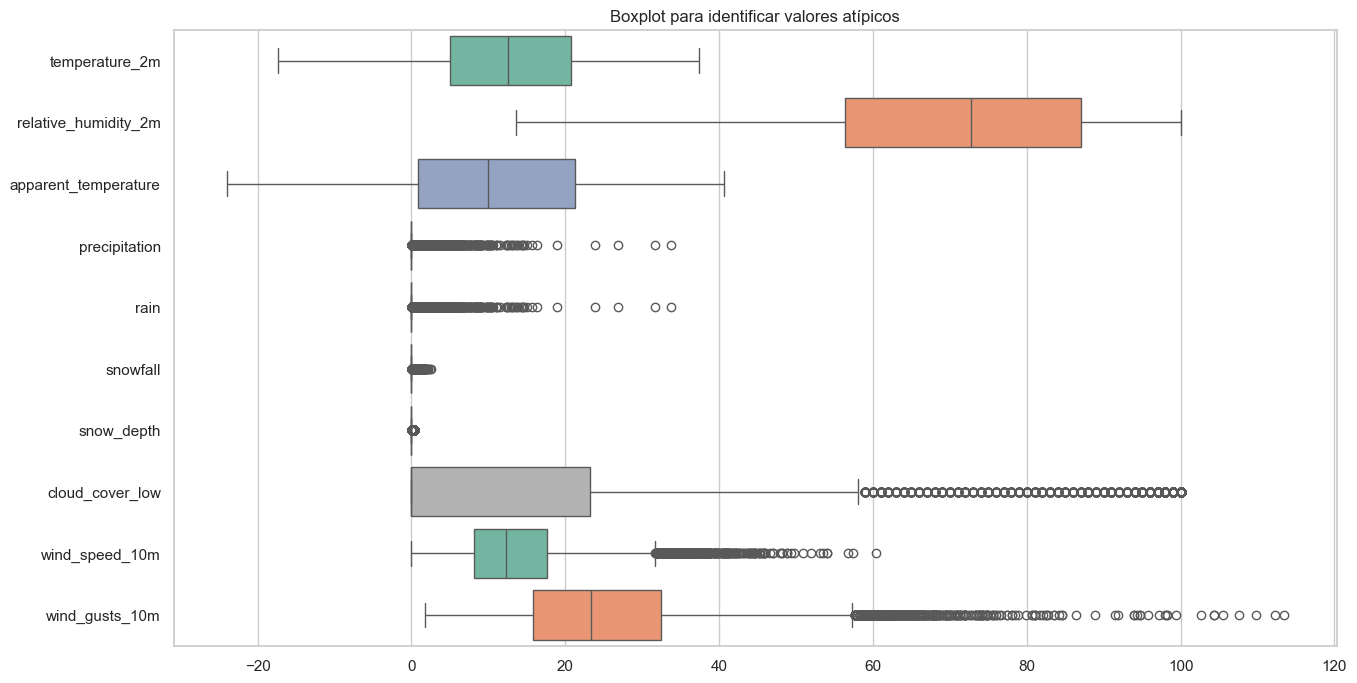

In [11]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear subgráficos de caja para cada columna numérica
plt.figure(figsize=(15, 8))
sns.boxplot(data=hourly_dataframe.drop(columns=['date']), orient="h", palette="Set2")

# Mostrar el gráfico
plt.title("Boxplot para identificar valores atípicos")
plt.show()

Los outliers de las variables, no serán removidos o reemplazados por lo siguiente:
- Aportan información valiosa en cuanto a eventos inusuales o situaciones extremas.
- Eventos extremos como tormentas, lluvias o nevados intensos.
- Preservar la distribución final original para mantener la distribución original.

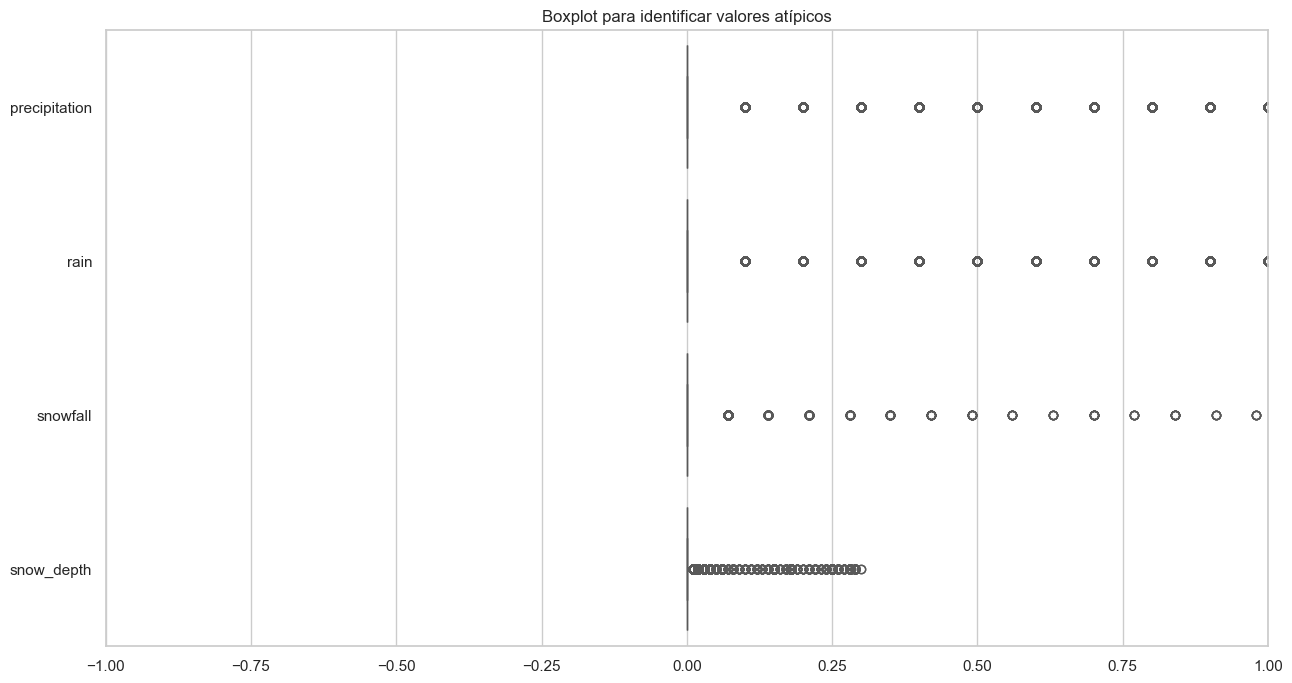

In [12]:
# Analizamos 'precipitation','rain','snowfall','snow_depth'.
sns.set(style="whitegrid")

plt.figure(figsize=(15, 8))
ax = sns.boxplot(data=hourly_dataframe[['precipitation','rain','snowfall','snow_depth']], 
            orient="h", palette="Set2")
# Configurar el rango en el eje X
new_xlim = (-1, 1)  # Define tus límites personalizados
ax.set_xlim(new_xlim)

plt.title("Boxplot para identificar valores atípicos")
plt.show()

In [13]:
# Agrupamos nuestras mediciones por el promedio semanal
semanal = hourly_dataframe.resample('W', on = 'date').mean()

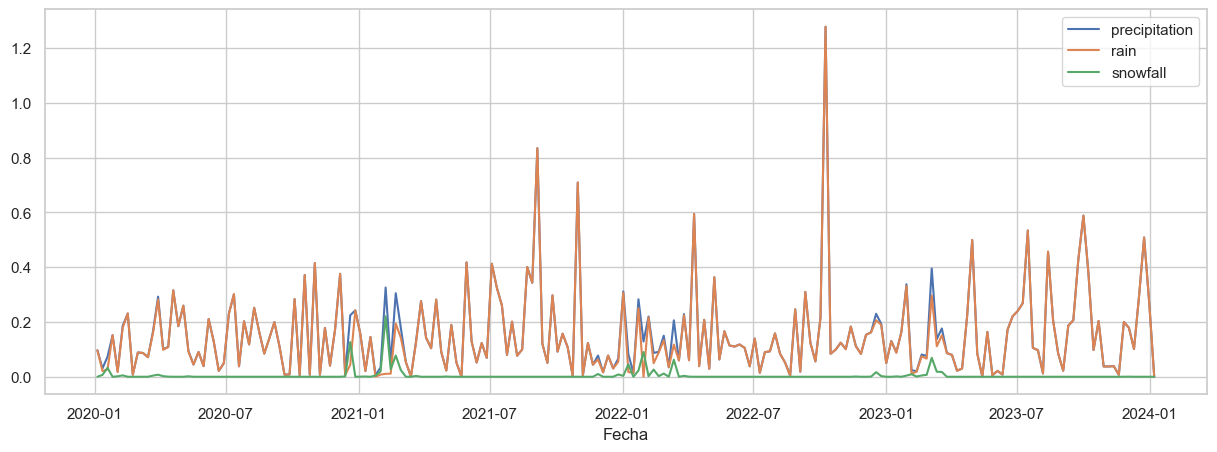

In [14]:
# Verificamos similitud entre precipitation, rain y snowfall
plt.figure(figsize = (15,5))

plt.plot(semanal.index, semanal.precipitation, label = 'precipitation')
plt.plot(semanal.index, semanal.rain, label = 'rain')
plt.plot(semanal.index, semanal.snowfall, label = 'snowfall')
plt.xlabel('Fecha')
plt.ylabel('')
plt.legend()
plt.show()

Con base en la estructura del conjunto de datos, donde la precipitación se define como la suma de la lluvia (rain), la nieve (snow), y otras formas de precipitación, se prestará especial atención a las variables **rain** y **snowfall**. Es importante tener en cuenta que la unidad de medida para la lluvia es milímetros (mm), y la unidad de medida para la acumulación de nieve (snowfall) está en centimetros (cm).


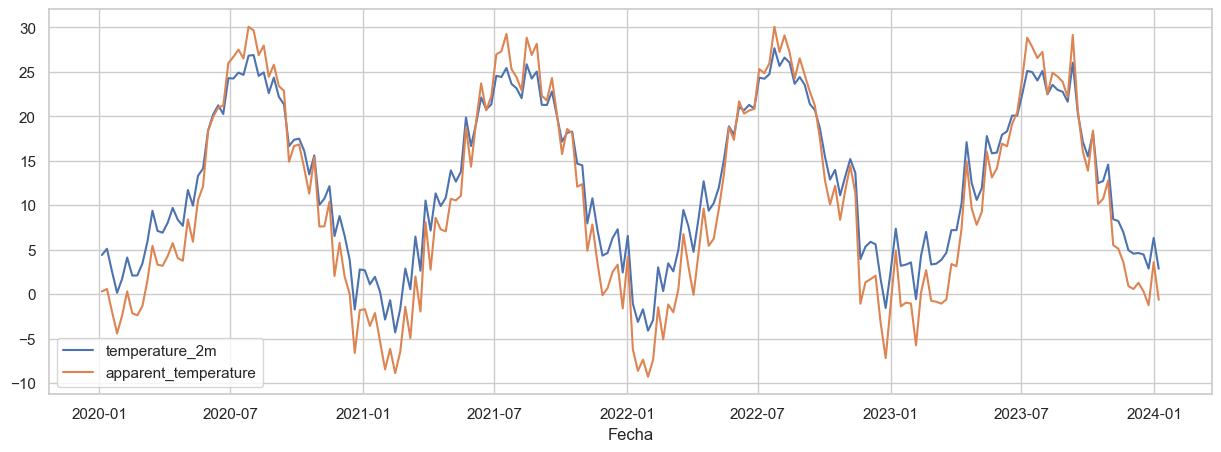

In [15]:
# Verificamos similitud entre 'temperature_2m' y 'apparent_temperature'
plt.figure(figsize = (15,5))

plt.plot(semanal.index, semanal.temperature_2m, label = 'temperature_2m')
plt.plot(semanal.index, semanal.apparent_temperature, label = 'apparent_temperature')
plt.xlabel('Fecha')
plt.ylabel('')
plt.legend()
plt.show()

Ambas variables cuentan con la misma unidad de medida, pero la diferencia entre la temperatura real y la temperatura aparente radica en que la temperatura aparente es el resultado de la combinación de factores climáticos como el viento, la humedad y la radiación solar. Por lo tanto, hemos decidido priorizar la variable **apparent_temperature** debido a que representa de manera más completa la percepción térmica, teniendo en cuenta estos factores climáticos adicionales.


In [16]:
# Actualizamos el Dataframe sin la columna precipitation y temperature_2m
hourly_dataframe = hourly_dataframe.drop(columns=['precipitation', 'temperature_2m'])
hourly_dataframe.head()

,date,relative_humidity_2m,apparent_temperature,rain,snowfall,snow_depth,cloud_cover_low,wind_speed_10m,wind_gusts_10m
0,2020-01-01 05:00:00,73.92,-1.81,0.00,0.00,0.00,0.00,17.67,29.16
1,2020-01-01 06:00:00,76.48,-2.89,0.00,0.00,0.00,0.00,16.56,29.16
2,2020-01-01 07:00:00,78.97,-3.39,0.00,0.00,0.00,0.00,16.56,27.72
3,2020-01-01 08:00:00,76.90,-4.15,0.00,0.00,0.00,0.00,18.72,31.68
4,2020-01-01 09:00:00,76.27,-4.36,0.00,0.00,0.00,0.00,17.34,31.32


### Estructura del Dataset Resultante

| Variable                              | Valid time            | Unit         | Description                                                                                                              |
|---------------------------------------|-----------------------|--------------|--------------------------------------------------------------------------------------------------------------------------|  
| relative_humidity_2m                  | Instant               | %            | Relative humidity at 2 meters above ground                                                                              |
| apparent_temperature                  | Instant               | °C (°F)      | Apparent temperature is the perceived feels-like temperature combining wind chill factor, relative humidity, and solar radiation |
| rain                                  | Preceding hour sum    | mm (inch)    | Only liquid precipitation of the preceding hour including local showers and rain from large scale systems.             |
| snowfall                              | Preceding hour sum    | cm (inch)    | Snowfall amount of the preceding hour in centimeters. For the water equivalent in millimeter, divide by 7. E.g. 7 cm snow = 10 mm precipitation water equivalent |
| snow_depth                            | Instant               | meters       | Snow depth on the ground. Snow depth in ERA5-Land tends to be overestimated. As the spatial resolution for snow depth is limited, please use it with care. |
| cloud_cover_low                       | Instant               | %            | Low level clouds and fog up to 2 km altitude                                                                            |
| wind_speed_10m                        | Instant               | km/h (mph, m/s, knots) | Wind speed at 10 or 100 meters above ground. Wind speed on 10 meters is the standard level.                         |
| wind_gusts_10m                        | Instant               | km/h (mph, m/s, knots) | Gusts at 10 meters above ground of the indicated hour. Wind gusts in CERRA are defined as the maximum wind gusts of the preceding hour. Please consult the ECMWF IFS documentation for more information on how wind gusts are parameterized in weather models. |

Hecho por Leonel Cortez